## dataload

In [40]:
import mlflow
import mlflow.lightgbm
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas as pd
import os
import random
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
from utils import custom_train_test_split, lgbm_predict, post_slack, title2filename
os.environ["LOGNAME"]='cwj'
SEED=13

## 1. 데이터 로딩
data_dir = '/opt/ml/input/data' # 경로
after_fe_path = os.path.join(data_dir, 'lgbm_ass_difficulty.pkl')
df = pd.read_pickle(after_fe_path)

train_df = df[df.kind=='train']
train, valid = custom_train_test_split(train_df, ratio=0.7, seed=SEED) # 훈련데이터 split
test = df[df.kind=='test'] # 테스트 데이터
train2 = test[test.answerCode!=-1] # 테스트데이터 마지막 제출 2번쨰꺼까지 훈련데이터로 사용
train = pd.concat([train,train2]) # 훈련데이터 병합
train.shape, valid.shape, test.shape

x_train = train.drop('answerCode',axis=1)
y_train = train[['answerCode']]

x_valid = valid.drop('answerCode',axis=1)
y_valid = valid[['answerCode']]
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((1845539, 47), (1974, 47), (260114, 47))

((1845539, 46), (1845539, 1), (1974, 46), (1974, 1))

## Hyper Parameter 설정

In [41]:
# Hyper parameter 설정
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
    "learning_rate": 0.023,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}

In [24]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day',
       'hour', 'dayname', 'big_category', 'problem_num', 'mid_category',
       'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum',
       'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category',
       'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut',
       'big_category_answer', 'big_category_user_cum_acc',
       'mid_category_cumconut', 'mid_category_answer',
       'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_acc_std',
       'pb_num_acc_mean', 'pb_num_acc_std'],
      dtype='object')

## ass_acc_mean 추가 - 성능 향상

In [17]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'ass_acc_mean'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM ass_acc_mean 추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model3 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model3.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model3_run_id=run.info.run_id
    post_slack("done")
    print(f"{model3_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model3, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/04 Sun)[LGBM ass_acc_mean 추가] 피처: 29개',
 '사용된 피처(29)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, ass_acc_mean')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19964
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.538933
[200]	valid_0's binary_logloss: 0.522742
[300]	valid_0's binary_logloss: 0.518416
[400]	valid_0's binary_logloss: 0.51688
[500]	valid_0's binary_logloss: 0.515875
[600]	valid_0's binary_logloss: 0.515268
[700]	valid_0's binary_logloss: 0.514868
[800]	valid_0's binary_logloss: 0.514311
[900]	valid_0's binary_logloss: 0.513801
[1000

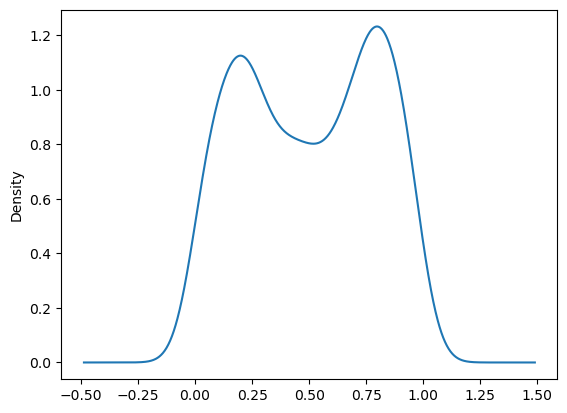

In [19]:
q = pd.Series(test_preds).plot(kind='kde')

In [20]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.8190
run_id = 'ad6c0253c9bd4f4d9557988b0a482e99'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

<ActiveRun: >

Active run_id: ad6c0253c9bd4f4d9557988b0a482e99


## ass_acc_std 추가 - 성능 감소

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/05 Mon)[LGBM ass_acc_std 추가] 피처: 30개',
 '사용된 피처(30)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, ass_acc_mean, ass_acc_std')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20219
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.53881
[200]	valid_0's binary_logloss: 0.522642
[300]	valid_0's binary_logloss: 0.518261
[400]	valid_0's binary_logloss: 0.516747
[500]	valid_0's binary_logloss: 0.515763
[600]	valid_0's binary_logloss: 0.515393
[700]	valid_0's binary_logloss: 0.515011
[800]	valid_0's binary_logloss: 0.51445
[900]	valid_0's binary_logloss: 0.514247
[1000]

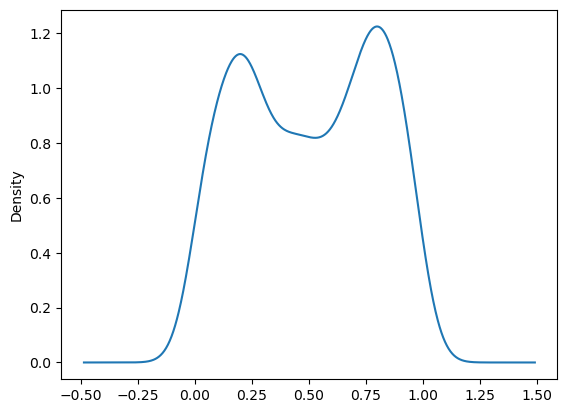

In [26]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'ass_acc_mean',
         'ass_acc_std'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM ass_acc_std 추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model4 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model4.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model4_run_id=run.info.run_id
    post_slack("done")
    print(f"{model4_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model4, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [ ]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.8190
run_id = 'ad6c0253c9bd4f4d9557988b0a482e99'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

## pb_num_acc_mean 추가 - 성능향상

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/05 Mon)[LGBM pb_num_acc_mean 추가] 피처: 30개',
 '사용된 피처(30)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, ass_acc_mean, pb_num_acc_mean')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19978
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.538933
[200]	valid_0's binary_logloss: 0.522525
[300]	valid_0's binary_logloss: 0.518109
[400]	valid_0's binary_logloss: 0.516598
[500]	valid_0's binary_logloss: 0.515773
[600]	valid_0's binary_logloss: 0.515371
[700]	valid_0's binary_logloss: 0.5148
[800]	valid_0's binary_logloss: 0.514101
[900]	valid_0's binary_logloss: 0.513615
[1000]

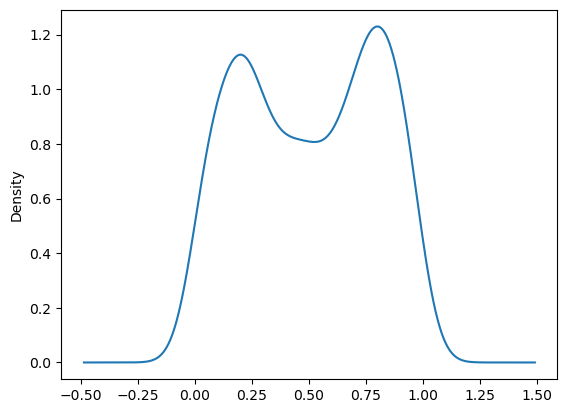

In [29]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'ass_acc_mean',
         'pb_num_acc_mean',
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM pb_num_acc_mean 추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model5 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model5.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model5_run_id=run.info.run_id
    post_slack("done")
    print(f"{model5_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model5, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [ ]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.8190
run_id = 'ad6c0253c9bd4f4d9557988b0a482e99'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

## pb_num_acc_std 추가 -> 성능감소

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/05 Mon)[LGBM pb_num_acc_std 추가] 피처: 31개',
 '사용된 피처(31)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, ass_acc_mean, pb_num_acc_mean, pb_num_acc_std')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19992
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.538933
[200]	valid_0's binary_logloss: 0.522827
[300]	valid_0's binary_logloss: 0.518476
[400]	valid_0's binary_logloss: 0.516761
[500]	valid_0's binary_logloss: 0.516039
[600]	valid_0's binary_logloss: 0.515632
[700]	valid_0's binary_logloss: 0.515014
[800]	valid_0's binary_logloss: 0.514496
[900]	valid_0's binary_logloss: 0.513775
[100

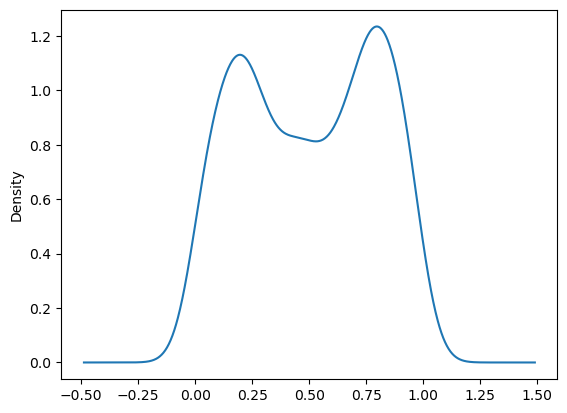

In [31]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'ass_acc_mean',
         'pb_num_acc_mean',
         'pb_num_acc_std',
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM pb_num_acc_std 추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model6 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model6.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model6_run_id=run.info.run_id
    post_slack("done")
    print(f"{model6_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model6, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [ ]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.8190
run_id = 'ad6c0253c9bd4f4d9557988b0a482e99'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

## 필요 없어보이는 피처 제거해보기

### test_std, tag_std 제거 -> 성능 감소

([0, 1, 2, 3, 6, 7, 8, 9, 11, 19, 21],
 '🌈(12/05 Mon)[LGBM test_std, tag_std 제거] 피처: 28개',
 '사용된 피처(28)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, ass_acc_mean, pb_num_acc_mean')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19468
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.538732
[200]	valid_0's binary_logloss: 0.522723
[300]	valid_0's binary_logloss: 0.518535
[400]	valid_0's binary_logloss: 0.516905
[500]	valid_0's binary_logloss: 0.516075
[600]	valid_0's binary_logloss: 0.515711
[700]	valid_0's binary_logloss: 0.51514
[800]	valid_0's binary_logloss: 0.514401
[900]	valid_0's binary_logloss: 0.513927
[1000

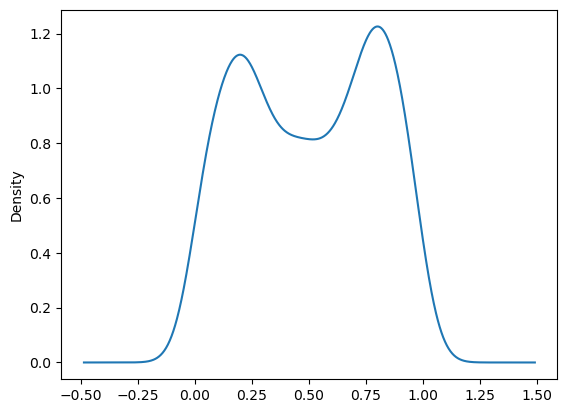

In [32]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'ass_acc_mean',
         'pb_num_acc_mean',
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM test_std, tag_std 제거] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model71 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model71.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model71_run_id=run.info.run_id
    post_slack("done")
    print(f"{model71_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model71, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [ ]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.8190
run_id = 'ad6c0253c9bd4f4d9557988b0a482e99'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

## ass_difficulty 추가 - 

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/05 Mon)[LGBM ass_difficulty 추가] 피처: 29개',
 '사용된 피처(29)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, ass_difficulty')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19964
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.538455
[200]	valid_0's binary_logloss: 0.522034
[300]	valid_0's binary_logloss: 0.518143
[400]	valid_0's binary_logloss: 0.516447
[500]	valid_0's binary_logloss: 0.51555
[600]	valid_0's binary_logloss: 0.515313
[700]	valid_0's binary_logloss: 0.514561
[800]	valid_0's binary_logloss: 0.5141
[900]	valid_0's binary_logloss: 0.513567
[1000]	

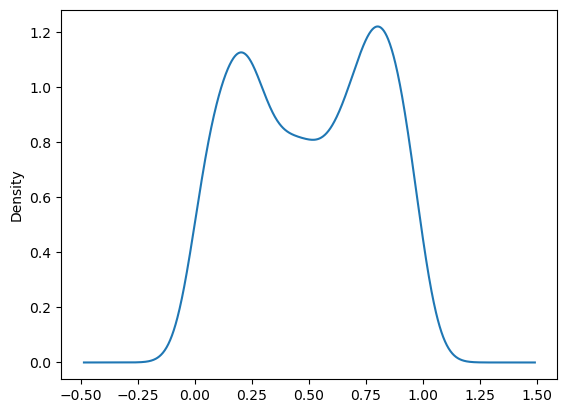

In [36]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'ass_difficulty'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM ass_difficulty 추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model8 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model8.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model8_run_id=run.info.run_id
    post_slack("done")
    print(f"{model8_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model8, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [ ]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.8190
run_id = 'ad6c0253c9bd4f4d9557988b0a482e99'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

## pb_num_difficulty 추가 - val auc 최대 성능

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/05 Mon)[LGBM pb_num_difficulty 추가] 피처: 30개',
 '사용된 피처(30)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, ass_difficulty, pb_num_difficulty')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19978
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.538455
[200]	valid_0's binary_logloss: 0.522034
[300]	valid_0's binary_logloss: 0.517878
[400]	valid_0's binary_logloss: 0.515872
[500]	valid_0's binary_logloss: 0.51487
[600]	valid_0's binary_logloss: 0.514511
[700]	valid_0's binary_logloss: 0.513998
[800]	valid_0's binary_logloss: 0.513315
[900]	valid_0's binary_logloss: 0.5129
[1000]	

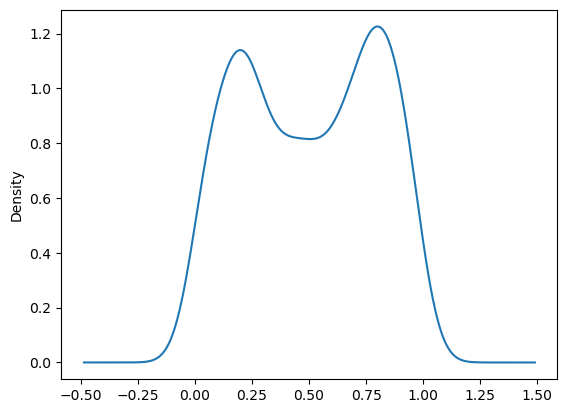

In [37]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'ass_difficulty',
         'pb_num_difficulty'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM pb_num_difficulty 추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model9 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model9.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model9_run_id=run.info.run_id
    post_slack("done")
    print(f"{model9_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model9, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [ ]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.8190
run_id = 'ad6c0253c9bd4f4d9557988b0a482e99'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

In [42]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day',
       'hour', 'dayname', 'big_category', 'problem_num', 'mid_category',
       'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum',
       'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category',
       'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut',
       'big_category_answer', 'big_category_user_cum_acc',
       'mid_category_cumconut', 'mid_category_answer',
       'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty',
       'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std',
       'know_tag_acc_mean', 'know_tag_difficulty'],
      dtype='object')

## know_tag_difficulty 추가 - 

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/05 Mon)[LGBM know_tag_difficulty 추가] 피처: 31개',
 '사용된 피처(31)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_cumconut, big_category_user_cum_acc, mid_category_cumconut, mid_category_user_cum_acc, ass_difficulty, pb_num_difficulty, know_tag_difficulty')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20233
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.538697
[200]	valid_0's binary_logloss: 0.522604
[300]	valid_0's binary_logloss: 0.518518
[400]	valid_0's binary_logloss: 0.516793
[500]	valid_0's binary_logloss: 0.516177
[600]	valid_0's binary_logloss: 0.515591
[700]	valid_0's binary_logloss: 0.515037
[800]	valid_0's binary_logloss: 0.514611
[900]	valid_0's binary_logloss: 0.514249
[100

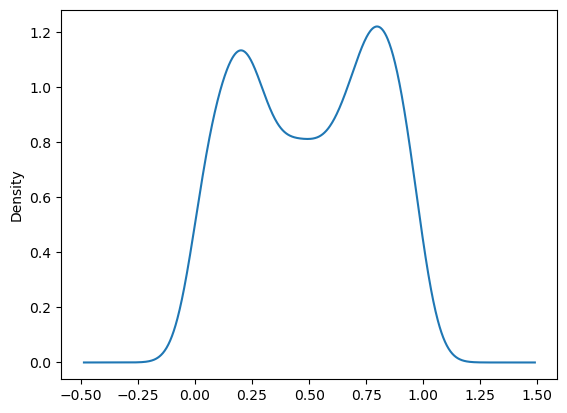

In [43]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_cumconut',
         'big_category_user_cum_acc',
         'mid_category_cumconut',
         'mid_category_user_cum_acc',
         'ass_difficulty',
         'pb_num_difficulty',
         'know_tag_difficulty'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM know_tag_difficulty 추가] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model10 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=100,
    )
    preds = model10.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model10_run_id=run.info.run_id
    post_slack("done")
    print(f"{model10_run_id=}")
    file_name = title2filename(title)
    test_preds = lgbm_predict(test, model10, FEATS, f'{file_name}.csv')

q = pd.Series(test_preds).plot(kind='kde')

In [ ]:
### 제출 mlflow 등록
# 제출시
LB_AUC=0.8190
run_id = 'ad6c0253c9bd4f4d9557988b0a482e99'
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()